In [19]:
import torch
import numpy as np

import h5py
from tqdm.notebook import tqdm
from datetime import datetime
import os

from methods.io_things import download
from methods.base import BaseConfig
from methods.deep_learning import TrainConfig, PermNet, ToTensor, Normalizer, EventsToPermDataset
from methods.plotting import plot_perm, plot_press_plan, plot_perm_with_contour, plot_loss_mask, \
    plot_masked_perm, plot_event_list, plot_lognorm_sigma, plot_ev_dens_slice, plot_error_vs_event_num

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Run the following cell to download model state and sample data 

In [23]:
if not os.path.exists('./data/'):
    os.makedirs('data')

if not os.path.exists('./model_states/'):
    os.makedirs('model_states')

# model weigths
download("https://huggingface.co/datasets/mexalon/microseicmic_events_to_permeability_map/resolve/main/permnet_wights.pt", './model_states/permnet_wights.pt')
# train dataset
download('https://huggingface.co/datasets/mexalon/microseicmic_events_to_permeability_map/resolve/main/train_mini_set.h5', './data/train_mini_set.h5')
# test dataset
download('https://huggingface.co/datasets/mexalon/microseicmic_events_to_permeability_map/resolve/main/test_mini_set.h5', './data/test_mini_set.h5')

permnet_wights.pt:   0%|          | 0.00/31.3M [00:00<?, ?iB/s]

train_mini_set.h5:   0%|          | 0.00/643M [00:00<?, ?iB/s]

test_mini_set.h5:   0%|          | 0.00/161M [00:00<?, ?iB/s]

### Training and Tuning

In [4]:
# tune proc
import wandb
import random

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

def trial_my_net(project, group, config):
    train_params = TrainConfig(**config)
    trial_id = f'trial_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}'
    to_wandb = {'trial': trial_id}
    to_wandb.update(train_params.__dict__)
    
    net = PermNet(train_h5_path, test_h5_path, train_params)
    
    with wandb.init(project=project, group=group, config=to_wandb):
        for epoch in range(train_params.epochs):
            losses = net.train_one_epoch()
            wandb.log(losses)
            net.save(f'trial_{trial_id}__epoch{epoch}__') # saving model state

wandb.login()
train_h5_path = f'train_mini_set.h5'
test_h5_path = f'test_mini_set.h5'

config = {'epochs' : 35, 'batch_size' : 60}
trial_my_net(project='permeability_reconstruction_network', group='general_training',  config=config)


### Testing and plotting

In [16]:
# datasets
train_h5_path = f'./data/train_mini_set.h5' # path to file
test_h5_path = f'./data/test_mini_set.h5'

# net setup
transforms = [ToTensor(), Normalizer(),] # data transformations
test = EventsToPermDataset(h5_path = test_h5_path, transforms=transforms)
train_params = TrainConfig(batch_size = 200) # batch_size for error testing
net = PermNet(train_h5_path, test_h5_path, train_params)
net.load_weights('./model_states/permnet_wights.pt') # path to file

c:\!Work\Projects\permeability_reconstruction_network\.venv\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
#calculating mean errors, it will take a couple of minutes
lognorm_sigma_list = []

for ii, (X, y) in enumerate(tqdm(net.test_dl)):
    y_hat = net(X)
    diff = (y - y_hat).detach().cpu().numpy()
    std_diff = diff.std(axis=0)
    lognorm_sigma_list += [std_diff,]

lognorm_sigma = np.mean(np.array(lognorm_sigma_list), axis=0)

Ground truth Permeability map


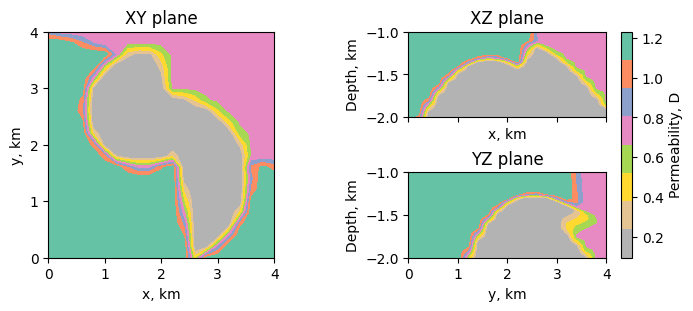

Model Permeability map


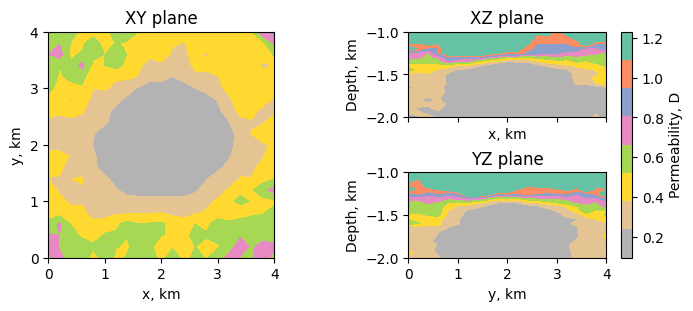

Pore pressure at the fimal step


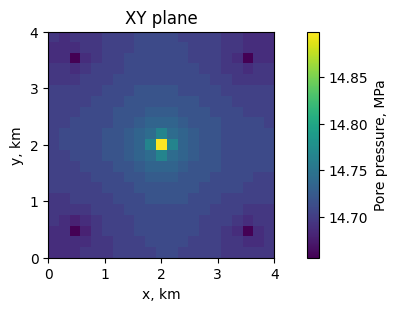

Events


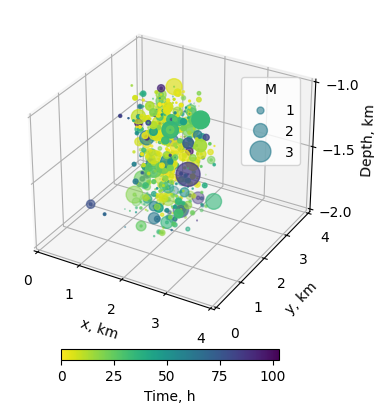

Seismic events in m3


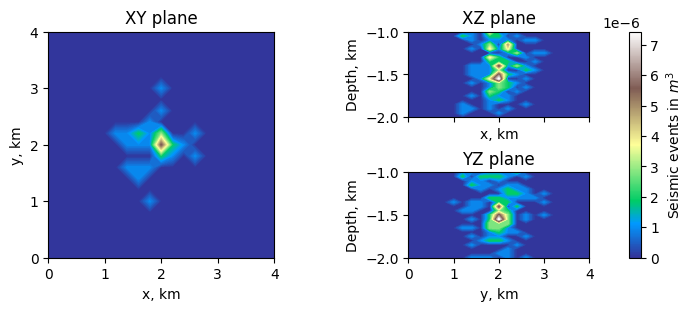

Permeability Lognorm error map


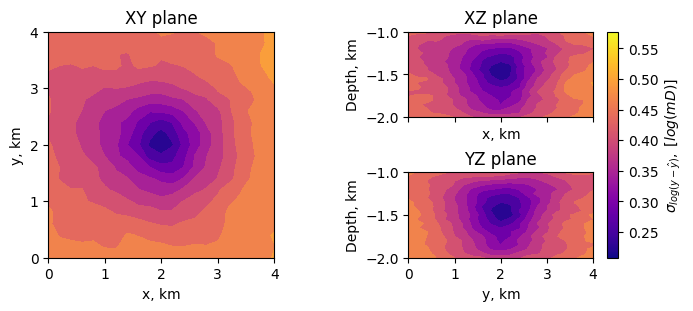

Loss mask


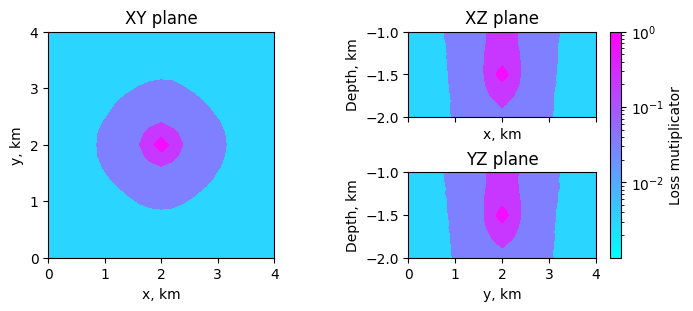

Ground truth Permeability map


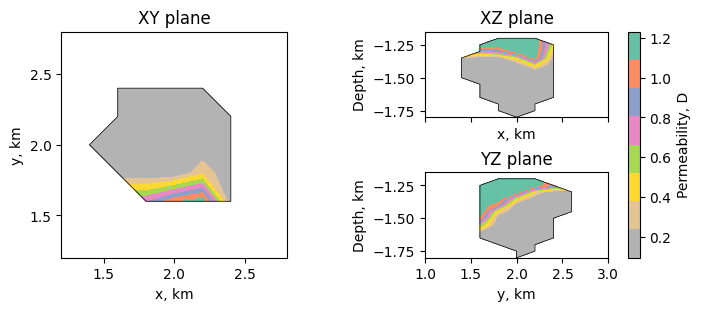

Masked Model Permeability map


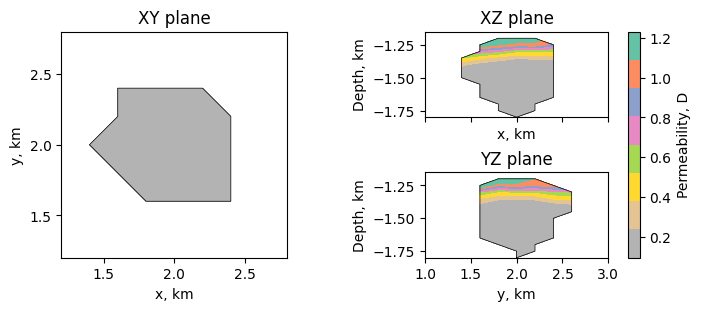

Ground truth Permeability map


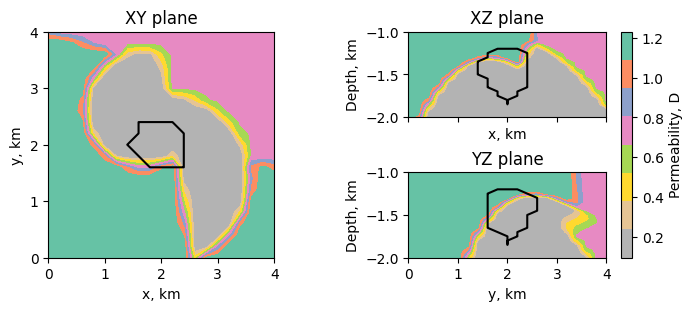

Masked Model Permeability map


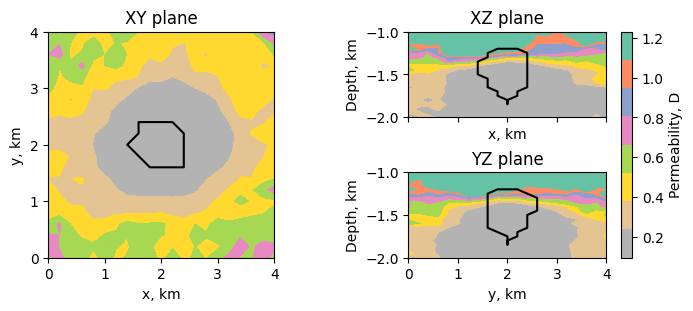

relative error vs event num


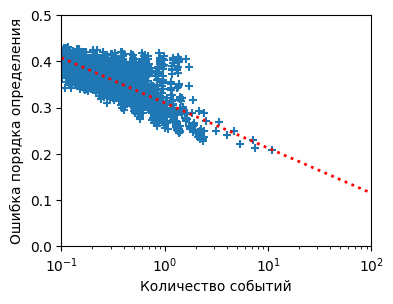

In [3]:
jj = 310 # some idx

x, y = test[jj]
y = y.numpy()
x = x.unsqueeze(0)
y_hat = net(x).squeeze(0).detach().numpy()

# plottint it all
params = BaseConfig()
params.load() # loading params from params.yaml
vmin_vmax = (10**np.min(y), 10**np.max(y)) # for same norms
loc=(10, 10, 10) # center point for horizontal and vertical slices

print('Ground truth Permeability map')
plot_perm(10**y, loc, params, vmin_vmax=vmin_vmax)

print('Model Permeability map')
plot_perm(10**y_hat, loc, params, vmin_vmax=vmin_vmax)

print('Pore pressure at the fimal step')
with h5py.File(test_h5_path, 'a') as f:
    pore = f['pore'][jj]

plot_press_plan(pore, loc, params)

print('Events')
with h5py.File(test_h5_path, 'a') as f:
    ev = f['events'][jj]
plot_event_list(ev[0:980], params=params)

print('Seismic events in m3')
with h5py.File(test_h5_path, 'a') as f:
    ev_d = f['ev_dens'][jj] # all events at final step, np.sum(ev_d) = 1000 events total

plot_ev_dens_slice(ev_d, loc, params)

print('Permeability Lognorm error map')
plot_lognorm_sigma(lognorm_sigma, loc, params)

print('Loss mask')
plot_loss_mask(net.mask.detach().cpu().numpy(), loc, params)

# mask for plotting
mask = np.ones_like(lognorm_sigma)
mask[lognorm_sigma > np.log10(2)] = 0

print('Ground truth Permeability map')
plot_masked_perm(10**y, mask, loc, params, vmin_vmax=vmin_vmax)

print('Masked Model Permeability map')
plot_masked_perm(10**y_hat, mask, loc, params, vmin_vmax=vmin_vmax)

print('Ground truth Permeability map')
plot_perm_with_contour(10**y, mask, loc, params, vmin_vmax=vmin_vmax)

print('Masked Model Permeability map')
plot_perm_with_contour(10**y_hat, mask, loc, params, vmin_vmax=vmin_vmax)

# error vs events
with h5py.File(train_h5_path, 'a') as f:
    ev_d = f['ev_dens'][:]
    mean_ev_d = np.mean(ev_d, axis=0)

print('relative error vs event num')
plot_error_vs_event_num(mean_ev_d, lognorm_sigma)